In [4]:
import pandas as pd
import glob
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table
from astropy.coordinates import match_coordinates_sky
from matplotlib.ticker import MaxNLocator
from utility import *

#### Density

In [2]:
def volume(r1, r2, omega):
    return 4/3 * np.pi * (r2**3 - r1**3) * omega / (4*np.pi)

def density(omega, para):
    
    T, log_g, Z = para
    
    F444W = magtable[
        (magtable['Teff'] == T) & (magtable['log(g)'] == log_g) & (magtable['Z'] == Z)
    ]['F444W'].values[0]
    print(f'F444W: {F444W}')
    
    lim_mag = 28.17

    D = 10 * np.sqrt(10**((lim_mag - F444W)/2.5))
    print(f'D: {D}')
    
    return 1 / volume(0, D, omega)

magtable = pd.read_csv('./CentralDogma/5_Wrath_/AB_mag.csv')
result = pd.read_csv('./CentralDogma/5_Wrath_/mcmc_result.csv')

theta = 243.0 # arcmin^2
# theta = 10.0 # arcmin^2
# convert to steradian
omega = theta/3600 * (np.pi/180)**2

In [21]:
volume(0, 4210, omega)

511426.86881119065

In [43]:
3.1e13/86400/3600/360*6.28/360

4.829476896306458

In [65]:
print(150/np.cos(41.91*np.pi/180), 500/np.cos(41.91*np.pi/180))

201.56008144651486 671.8669381550495


In [17]:
n = 8
print( n / volume(0, 4210, omega), np.sqrt(n) / volume(0, 4210, omega))

1.5642510176667023e-05 5.530462510350416e-06


In [79]:
#  5, 4, 8
8 / volume(201, 671, omega)

0.0964772263491283

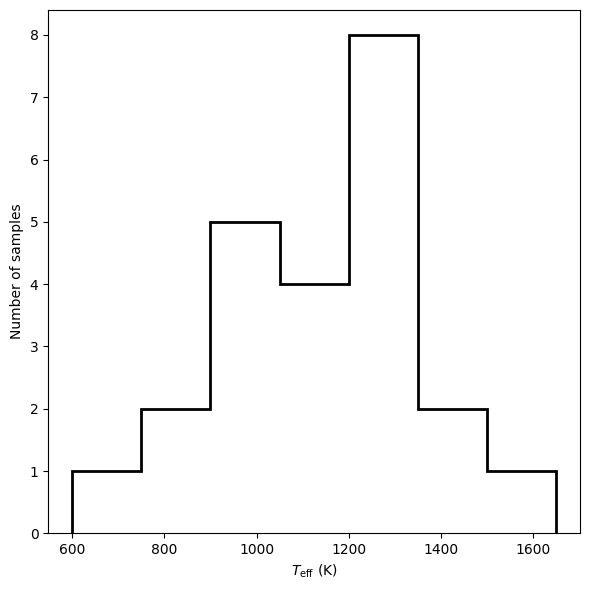

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

bins = [600, 750, 900, 1050, 1200, 1350, 1500, 1650]

# ax.hist(result[result['distance_peak']<671]['T_eff'], bins=bins, histtype='step', color='k', lw=2)
# ax.hist(result[result['distance_peak']>671]['T_eff'], bins=bins, histtype='step', color='r', lw=2)
ax.hist(result['T_eff'], bins=bins, histtype='step', color='k', lw=2)

ax.set_xlabel(r'$T_{\rm eff}$ (K)')
ax.set_ylabel('Number of samples')

plt.tight_layout()
plt.show()

#### expected number

In [83]:
def volume(r1, r2, omega):
    return 4/3 * np.pi * (r2**3 - r1**3) * omega / (4*np.pi)

def doubleE_model(r, l, b, n0):
    
    ''' double exponential model from Ryan & Reid 2016 
    Parameters
    ----------
    r : float
        geocentric distance in pc
    l : float
        Galactic longitude in degree
    b : float
        Galactic latitude in degree
    n0 : float
        local star density in pc^-3
    Returns
    -------
    density : float
        star density in pc^-3
    '''
    
    n0 = n0 * 1e-3 * 0.0524/0.00195 # scaled from Kirkpatrick et al. 2012, density at 20 pc
    
    R_Sun = 8000 # pc
    z_Sun = 25 # pc
    
    R = np.sqrt(
        R_Sun**2 + (r * np.cos(b*np.pi/180))**2 - 2*r*R_Sun * np.cos(b*np.pi/180) * np.cos(l*np.pi/180)
    )
    Z = z_Sun + r * np.sin(b*np.pi/180)
    # print(f'R: {R}, Z: {Z}')
    
    density = n0 * np.exp(-R/2500) * np.exp(-np.abs(Z)/290)
    
    return density

def expected_number(omega, para, n0):
    
    # setup the detection distance limit
    T, log_g, Z = para
    magtable = pd.read_csv('./CentralDogma/5_Wrath_/AB_mag.csv')
    F444W = magtable[
        (magtable['Teff'] == T) & (magtable['log(g)'] == log_g) & (magtable['Z'] == Z)
    ]['F444W'].values[0]
    print(f'F444W: {F444W}')
    lim_mag = 28.17
    D = 10 * np.sqrt(10**((lim_mag - F444W)/2.5))
    print(f'D: {D}')
    
    # calculate the expected number of stars
    omega = omega/3600 * (np.pi/180)**2
    l, b = 236.825, 42.116 # degree, for COSMOS field
    # integral the double exponential model
    N = np.sum([doubleE_model(r, l, b, n0)*volume(r, r+(D-201)/1e4, omega) for r in np.linspace(201, D, int(1e4))])
    
    return N

In [91]:
expected_number(243, [1300, 5.0, 0.5], 1.11), expected_number(243, [1300, 5.0, 0.5], 0.25)

F444W: 14.72731562228223
D: 4881.315462870142
F444W: 14.72731562228223
D: 4881.315462870142


(2.932573171440713, 0.6604894530271876)

In [68]:
l, b = 236.825, 42.116 # degree, for COSMOS field
# l, b = 0, 0
# doubleE_model(20, l, b, 1e-3 * 1.95*0.0524/0.00195)
print(doubleE_model(20, l, b, 1.95), doubleE_model(0, l, b, 1.95))

0.0018731345271250435 0.0019651591963497157


In [56]:
r=0

R_Sun = 8000 # pc
z_Sun = 25 # pc

R = np.sqrt(
    R_Sun**2 + (r * np.cos(b*np.pi/180))**2 - 2*r*R_Sun * np.cos(b*np.pi/180) * np.cos(l*np.pi/180)
)

R

8000.0

In [54]:
np.cos(b*np.pi/180), np.cos(l*np.pi/180)

(0.7417885936173463, -0.547198064071655)

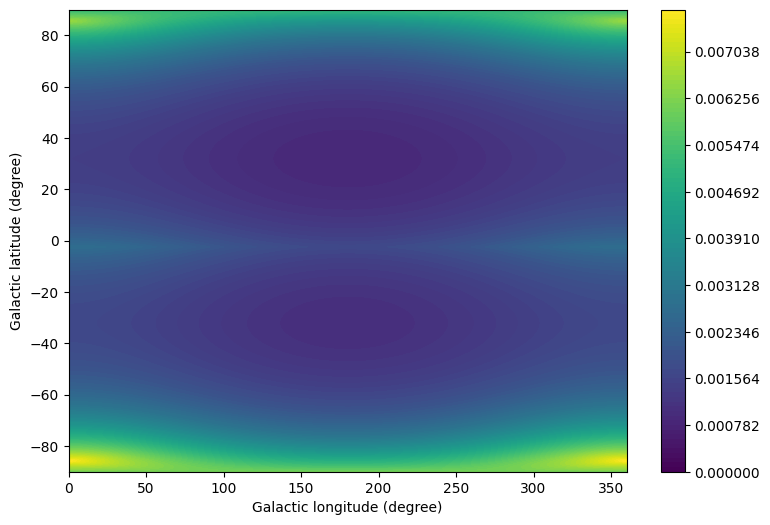

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))

l = np.linspace(0, 360, 1000)
b = np.linspace(-90, 90, 1000)

L, B = np.meshgrid(l, b)
density = doubleE_model(600, L, B, 1e-3 * 1.95* 0.0524/0.00195)

C = ax.contourf(L, B, density, levels=np.linspace(0, density.max(), 100), cmap='viridis')
colorbar = fig.colorbar(C, ax=ax)

ax.set_xlabel('Galactic longitude (degree)')
ax.set_ylabel('Galactic latitude (degree)')

plt.show()

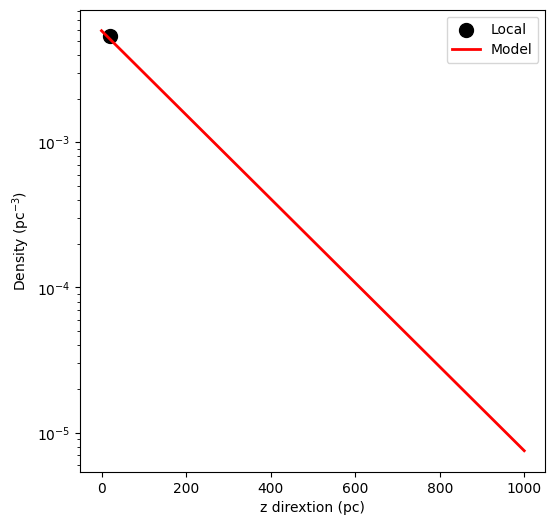

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

local = [20, 5.4e-3]
x = np.linspace(0, 1000, 100)

model = lambda x, a: a*np.exp(-x/150+80/25)

ax.scatter(local[0], local[1], color='k', s=100, label='Local')
ax.plot(x, model(x, 0.00024), color='r', lw=2, label='Model')

ax.set_xlabel('z dirextion (pc)')
ax.set_ylabel('Density (pc$^{-3}$)')
ax.set_yscale('log')
ax.legend()

plt.show()

### class star

In [7]:
source = pd.read_csv('CentralDogma/1_Limbo_/merged_catalog_5sig.csv',
                       usecols=['MAG_AUTO_F115W', 'CLASS_STAR_F115W'])

candidates = pd.read_csv('CentralDogma/4_Greed_/selected.csv',
                        usecols=['MAG_AUTO_F115W', 'CLASS_STAR_F115W'])

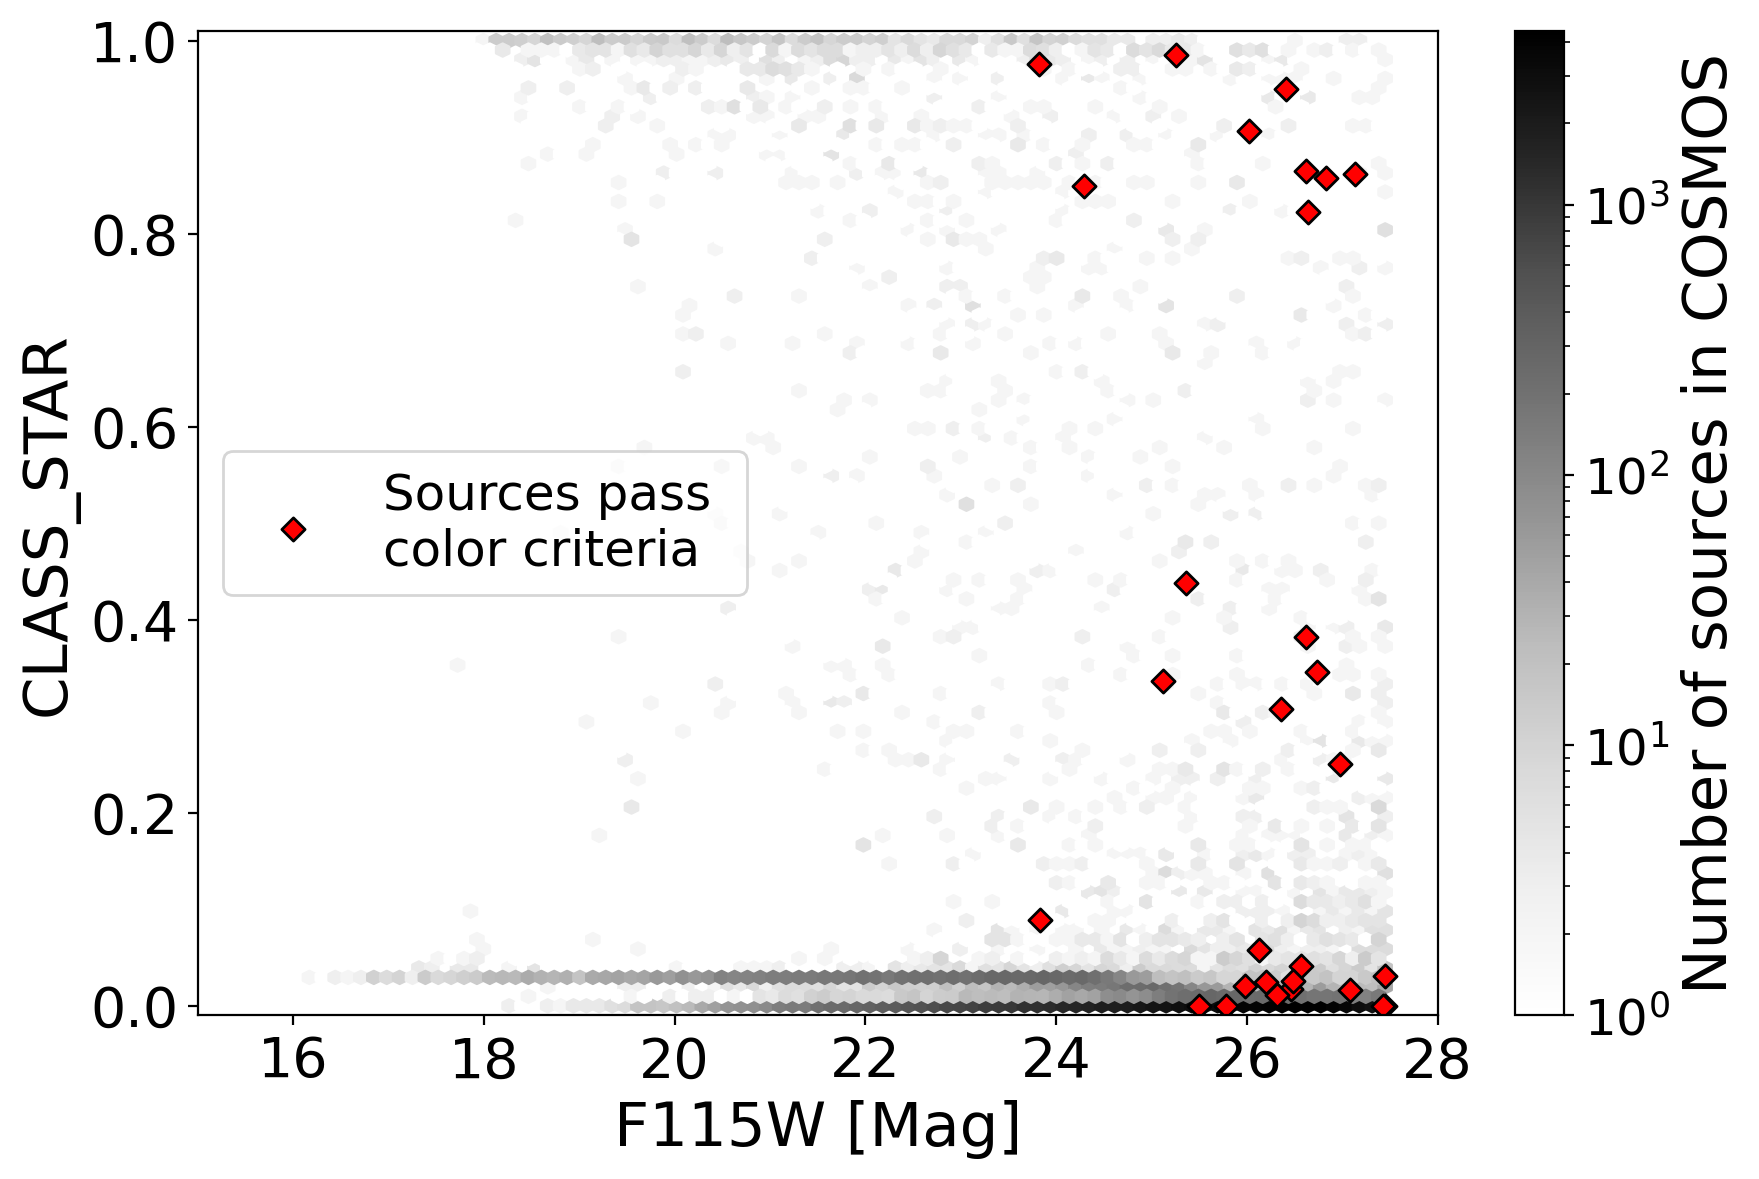

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6), dpi=200)

# ax.scatter(sourcev5['MAG_AUTO_F115W'], sourcev5['CLASS_STAR_F115W'],
#            s=5, c='gray', label='all sources')

hb = ax.hexbin(source['MAG_AUTO_F115W'], source['CLASS_STAR_F115W'], 
               gridsize=90, cmap='Greys', bins='log')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of sources in COSMOS', fontsize=22)
cb.ax.tick_params(labelsize=18)

ax.scatter(candidates['MAG_AUTO_F115W'], candidates['CLASS_STAR_F115W'],
              s=35, marker='D', c='red', edgecolors='black',
              label='Sources pass \ncolor criteria')


ax.set_xlabel('F115W [Mag]', fontsize=22)
ax.set_ylabel('CLASS_STAR', fontsize=22)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlim(15, 28)
ax.set_ylim(0-0.01, 1+0.01)

ax.legend(fontsize=18, loc='center left')
plt.tight_layout()
plt.savefig('louvre/115class_star.png')

### elongation flux_radius


In [2]:
# usecol = ['ALPHA_J2000_F444W', 'MAG_AUTO_F150W', 'FLUX_RADIUS_F150W', 'ELONGATION_F150W']
data = pd.read_csv('./CentralDogma/1_Limbo_/merged_catalog_5sig.csv',
                #    usecols=usecol
                   )
selected = pd.read_csv('./CentralDogma/4_Greed_/selected.csv',
                    #    usecols=usecol
                       )

In [14]:
selected.loc[
    (selected['FLUX_RADIUS_F115W']<2) & (selected['MAG_AUTO_F115W']<27)
]

,MAG_AUTO_F444W,MAGERR_AUTO_F444W,KRON_RADIUS_F444W,PETRO_RADIUS_F444W,ALPHA_J2000_F444W,DELTA_J2000_F444W,A_IMAGE_F444W,B_IMAGE_F444W,THETA_IMAGE_F444W,ELONGATION_F444W,...,PETRO_RADIUS_F115W,ALPHA_J2000_F115W,DELTA_J2000_F115W,A_IMAGE_F115W,B_IMAGE_F115W,THETA_IMAGE_F115W,ELONGATION_F115W,ELLIPTICITY_F115W,CLASS_STAR_F115W,FLUX_RADIUS_F115W
0,24.345978,0.006669,3.50,3.96,150.285545,1.746714,3.103,2.713,-47.64,1.143,...,3.96,150.285545,1.746714,1.330,1.273,-11.96,1.045,0.043,0.438,1.156
2,25.285140,0.013379,3.52,4.62,150.296834,1.811298,2.475,2.399,48.19,1.032,...,3.96,150.296833,1.811298,1.302,1.181,-62.66,1.102,0.093,0.017,1.342
3,23.453909,0.003230,3.50,3.50,150.175012,2.072088,3.498,3.167,67.80,1.104,...,3.50,150.175013,2.072088,1.579,1.493,73.84,1.058,0.054,0.976,1.232
6,25.637873,0.018736,3.76,4.62,150.294517,2.118126,2.542,2.287,67.05,1.112,...,3.96,150.294519,2.118124,1.312,1.170,-89.57,1.121,0.108,0.058,1.152
7,26.685791,0.054647,5.15,5.94,150.292481,2.132257,1.986,1.894,-56.67,1.049,...,3.96,150.292483,2.132254,1.169,1.030,-77.79,1.135,0.119,0.858,1.101
9,26.069635,0.028522,4.11,4.62,150.078841,2.036966,2.330,2.116,-23.92,1.101,...,3.96,150.078846,2.036970,1.207,1.123,74.65,1.075,0.070,0.308,1.136
11,24.517067,0.007882,3.50,3.96,150.189880,2.162042,3.201,2.800,-87.05,1.143,...,3.96,150.189876,2.162043,1.556,1.262,73.85,1.233,0.189,0.337,1.233
12,26.469245,0.038366,4.08,4.62,149.817840,1.948252,2.275,1.937,7.84,1.174,...,3.50,149.817837,1.948249,1.176,1.084,6.76,1.085,0.079,0.822,1.092
13,26.082398,0.024483,3.50,4.62,149.866039,1.966473,2.291,2.161,20.90,1.060,...,4.62,149.866037,1.966471,1.348,1.230,-65.20,1.096,0.087,0.025,1.312
14,25.897801,0.024919,4.05,5.28,149.876557,1.968080,2.389,2.240,-60.71,1.066,...,4.62,149.876559,1.968079,1.393,1.092,-83.91,1.275,0.216,0.041,1.333


In [3]:
selected.loc[selected['MAG_AUTO_F115W']>27]

,MAG_AUTO_F444W,MAGERR_AUTO_F444W,KRON_RADIUS_F444W,PETRO_RADIUS_F444W,ALPHA_J2000_F444W,DELTA_J2000_F444W,A_IMAGE_F444W,B_IMAGE_F444W,THETA_IMAGE_F444W,ELONGATION_F444W,...,PETRO_RADIUS_F115W,ALPHA_J2000_F115W,DELTA_J2000_F115W,A_IMAGE_F115W,B_IMAGE_F115W,THETA_IMAGE_F115W,ELONGATION_F115W,ELLIPTICITY_F115W,CLASS_STAR_F115W,FLUX_RADIUS_F115W
1,26.366202,0.047679,5.23,5.28,150.235096,1.786097,2.270,2.027,-38.34,1.120,...,3.96,150.235099,1.786092,1.068,1.023,-87.82,1.044,0.042,0.862,1.229
4,27.046512,0.093402,6.49,10.56,150.187686,2.102767,2.283,1.581,17.78,1.444,...,5.94,150.187697,2.102761,1.459,0.762,21.72,1.915,0.478,0.000,2.379
5,26.614737,0.070589,7.47,6.60,150.260863,2.101072,2.066,1.656,39.58,1.247,...,5.28,150.260863,2.101074,1.270,0.828,53.22,1.534,0.348,0.016,3.575
8,26.701695,0.087623,8.44,6.60,150.207853,2.163720,3.377,1.046,-66.99,3.229,...,5.28,150.207871,2.163710,2.530,1.092,-7.58,2.317,0.568,0.000,2.277
24,17.935412,0.000064,3.50,3.50,149.908405,2.152726,13.088,8.741,-82.78,1.497,...,0.00,149.908399,2.152738,77.095,32.045,-10.95,2.406,0.584,0.031,0.000


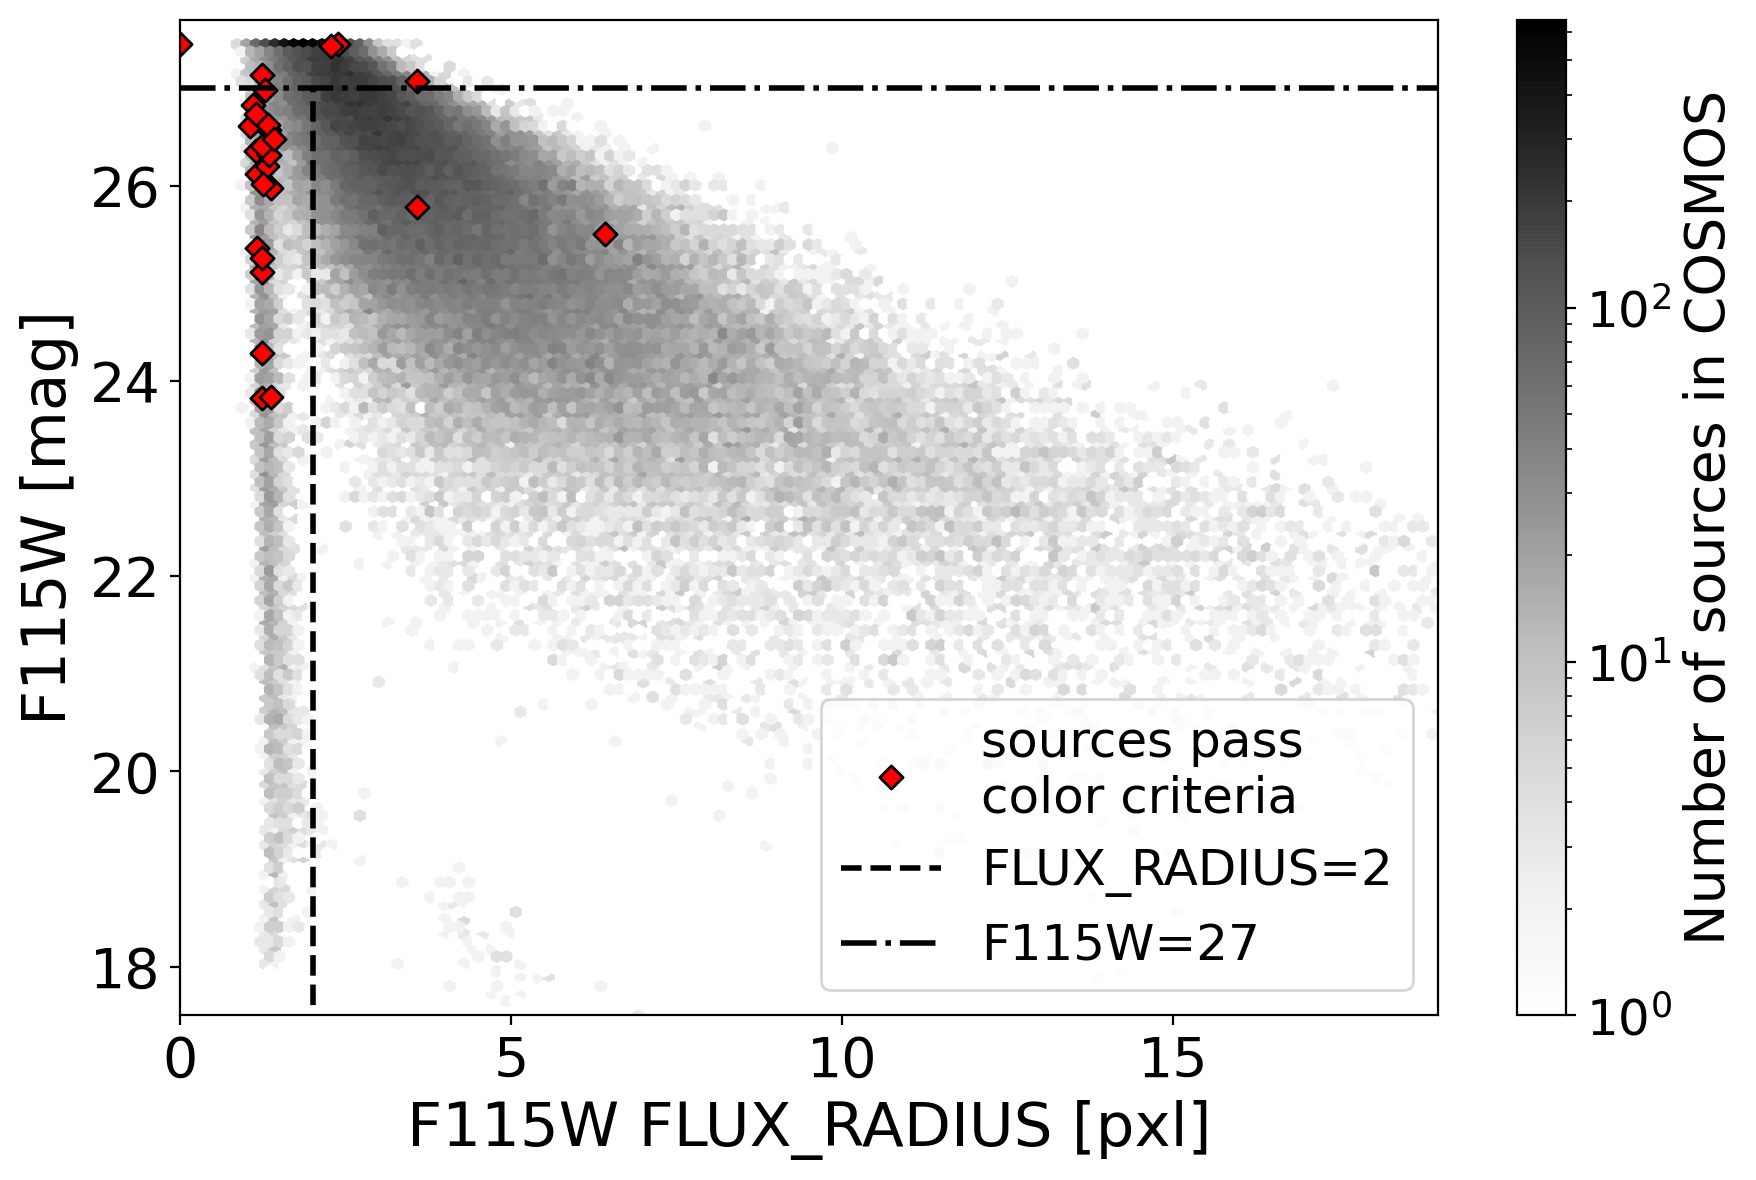

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6), dpi=200)

hb = ax.hexbin(data['FLUX_RADIUS_F115W'].loc[data['FLUX_RADIUS_F115W']<20], 
          data['MAG_AUTO_F115W'].loc[data['FLUX_RADIUS_F115W']<20],
          gridsize=140, cmap='Greys', bins='log')
# ax.scatter(data['FLUX_RADIUS_F115W'], data['MAG_AUTO_F115W'],
#         marker = 'o', s=1, c='k', edgecolors='k', 
#         label='sources pass \ncolor criteria')


cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of sources in COSMOS', fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.scatter(selected['FLUX_RADIUS_F115W'], selected['MAG_AUTO_F115W'],
        marker = 'D', s=35, c='red', edgecolors='k', 
        label='sources pass \ncolor criteria')

ax.plot([2, 2], [17, 27], 'k--', lw=2, label='FLUX_RADIUS=2')
ax.plot([0, 20], [27, 27], 'k-.', lw=2, label='F115W=27')

ax.set_ylabel('F115W [mag]', fontsize=22)
ax.set_xlabel('F115W FLUX_RADIUS [pxl]', fontsize=22)
ax.set_xlim(0, 19)
ax.set_ylim(17.5, 27.7)

# ax.set_xscale('log')

ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=18)

plt.tight_layout()

plt.savefig('louvre/fluxradius115.png')

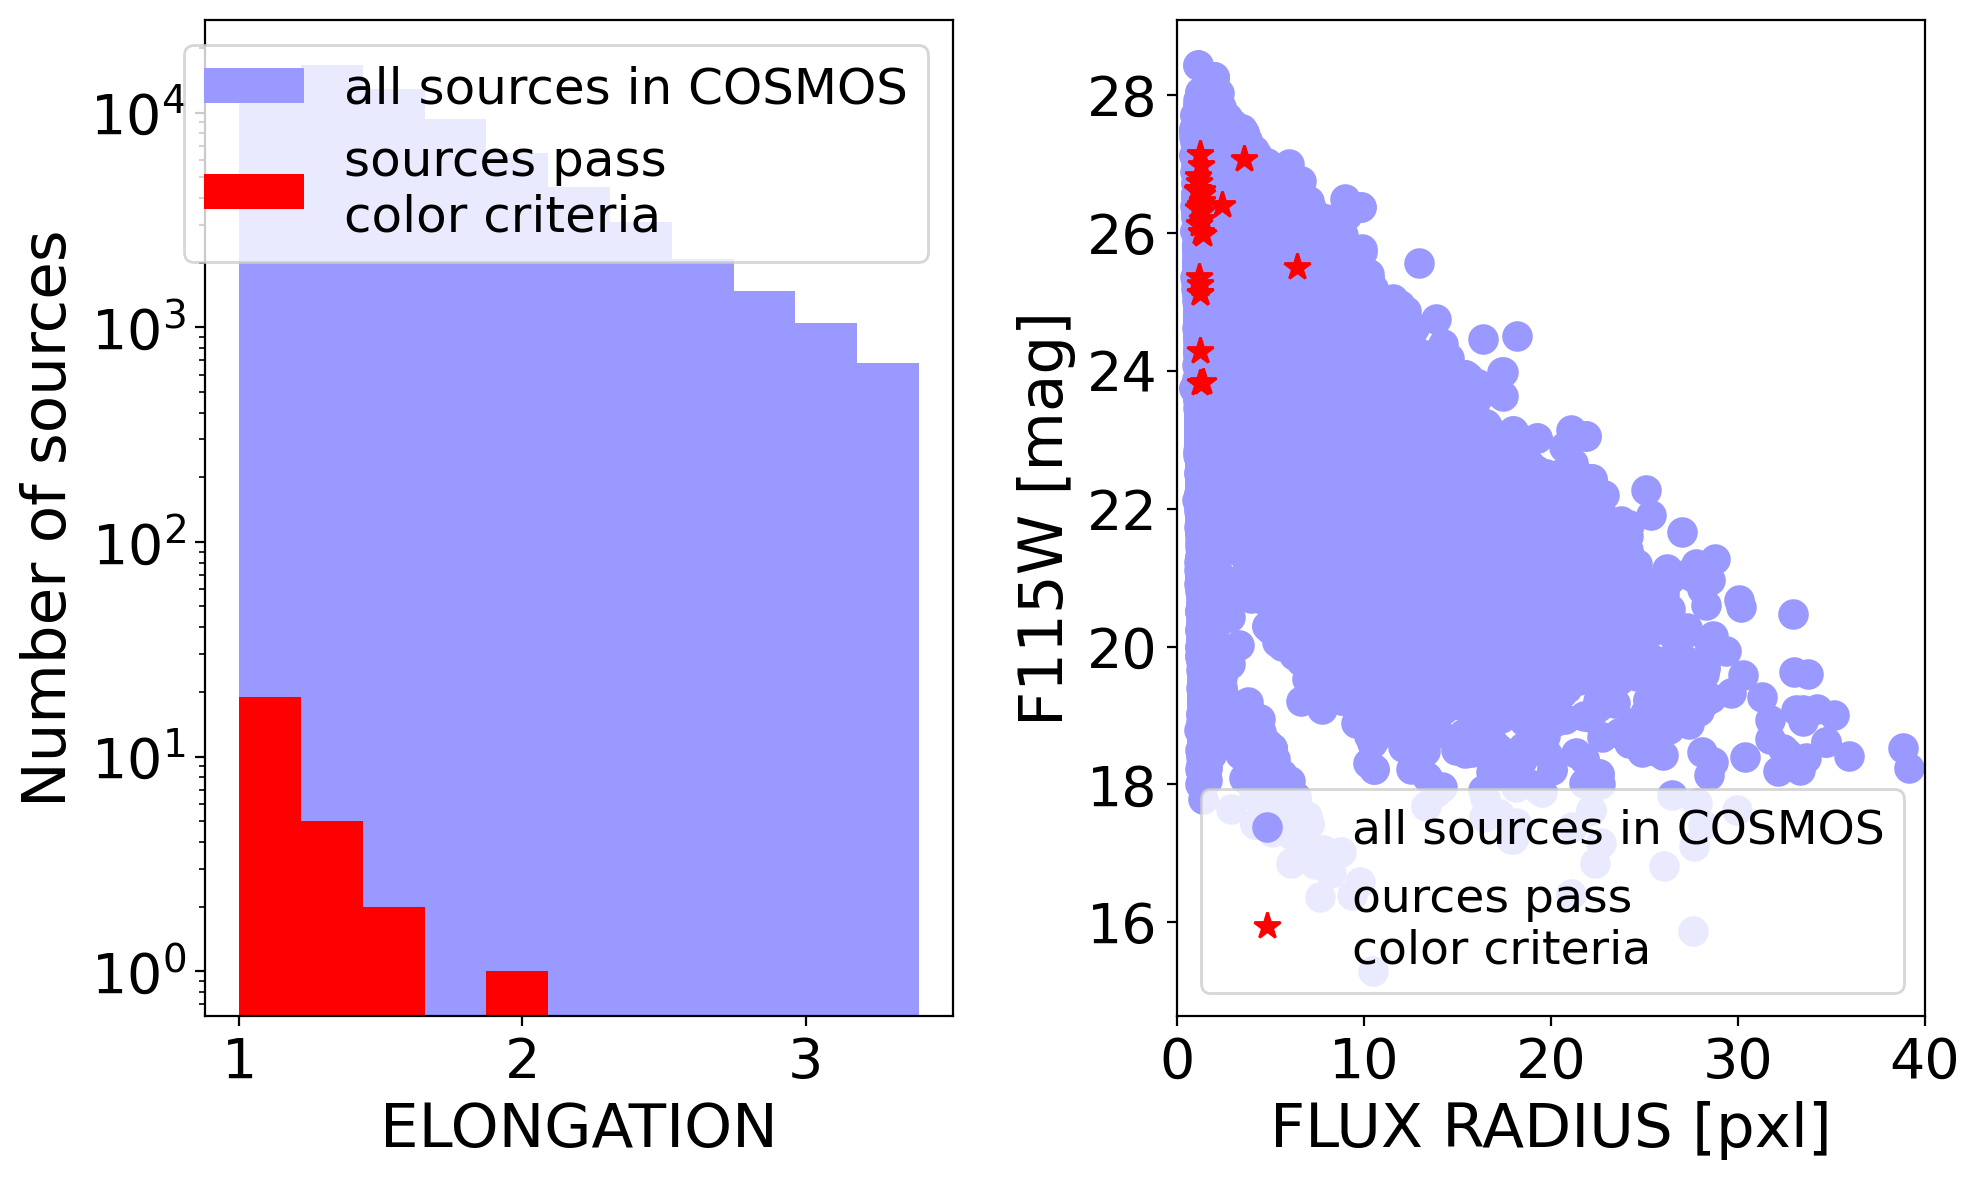

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10, 6), dpi=200)

bins=np.linspace(1, 3.4, 12)

ax = axs[0]

ax.hist(data['ELONGATION_F115W'], 
        bins=bins, color='#9999FF', alpha=1, 
        label='all sources in COSMOS')
# ax.hist(elongation(band)[0].loc[alldata[f"ELONGATION_{band}"]<1.5], 
#         bins=bins, color='#99FF99', alpha=1, 
#         label='elongation < 1.5')
ax.hist(selected['ELONGATION_F115W'], bins=bins, color='red', alpha=1, 
        label='sources pass \ncolor criteria')
ax.set_xlabel('ELONGATION', fontsize=22)
ax.set_ylabel('Number of sources', fontsize=22)
ax.set_yscale('log')

# ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=20)

ax.legend(fontsize=18)

ax = axs[1]

ax.plot(data['FLUX_RADIUS_F115W'], data['MAG_AUTO_F115W'], 'o', markersize=10, color='#9999FF', alpha=1, 
        label='all sources in COSMOS')
# ax.plot(fluxradius(band)[0].loc[alldata[f"ELONGATION_{band}"]<1.5],mag(band)[0].loc[alldata[f"ELONGATION_{band}"]<1.5], 
#         'D', markersize=6, color='#99FF99', alpha=1, 
#         label='ELONGATION<1.5')
ax.plot(selected['FLUX_RADIUS_F115W'], selected['MAG_AUTO_F115W'], '*', markersize=10, color='red', alpha=1,
        label='ources pass \ncolor criteria')
# ax.plot([0, 10], [0, 10], 'r--')
# ax.set_title(f'A vs B image {band}')
ax.set_ylabel('F115W [mag]', fontsize=22)
ax.set_xlabel('FLUX RADIUS [pxl]', fontsize=22)
ax.set_xlim(0, 40)

ax.tick_params(axis='both', which='major', labelsize=20)
ax.legend(fontsize=17)

plt.tight_layout()

plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed to prevent label overlap, after setting the labels
plt.show()

### Color Color plot

In [10]:
data = pd.read_csv('./CentralDogma/1_Limbo_/merged_catalog_5sig.csv')
# data = pd.read_csv('./CentralDogma/4_Greed_/JWST_merged.csv')
m444 = data['MAG_AUTO_F444W']
m277 = data['MAG_AUTO_F277W']
# m150 = data['MAG_AUTO_F150W']
m115 = data['MAG_AUTO_F115W']

selected = data.loc[(m277-m444>1.1)&(m115-m277<-0.8)]
selected.to_csv('./CentralDogma/4_Greed_/selected.csv', index=False)

In [37]:
def ccplot(data, magtype="AUTO", save=False):
    
    m444 = data[f'MAG_{magtype}_F444W']
    m277 = data[f'MAG_{magtype}_F277W']
    m115 = data[f'MAG_{magtype}_F115W']

    selected = data.loc[(m277 - m444 > 1.1) & (m115 - m277 < -0.8)]

    detected = selected.loc[(selected[f'MAGERR_{magtype}_F444W'] > 0) &
                            (selected[f'MAGERR_{magtype}_F277W'] > 0) &
                            (selected[f'MAGERR_{magtype}_F115W'] > 0)]
                            
    nondetect = selected.loc[(selected[f'MAGERR_{magtype}_F444W'] < 0) |
                             (selected[f'MAGERR_{magtype}_F277W'] < 0) |
                             (selected[f'MAGERR_{magtype}_F115W'] < 0)]

    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)

    # Plotting all sources
    ax.scatter(m277 - m444, m115 - m277, s=1, label='COSMOS-Webb sources', color='green', alpha=0.5)

    # Plotting detected candidates with error bars
    ax.errorbar(detected[f'MAG_{magtype}_F277W'] - detected[f'MAG_{magtype}_F444W'],
                detected[f'MAG_{magtype}_F115W'] - detected[f'MAG_{magtype}_F277W'],
                xerr=np.sqrt(detected[f'MAGERR_{magtype}_F277W']**2 + detected[f'MAGERR_{magtype}_F444W']**2), 
                yerr=np.sqrt(detected[f'MAGERR_{magtype}_F115W']**2 + detected[f'MAGERR_{magtype}_F277W']**2),
                color='red', ls='', lw=1, fmt='.', label=f'{len(detected)} Detected candidates')

    # Plotting lines to mark selection criteria
    ax.plot([1.1, 1.1], [-4, -0.8], color='black', lw=1, alpha=0.5)
    ax.plot([1.1, 5], [-0.8, -0.8], color='black', lw=1, alpha=0.5)

    # Adding arrows for non-detected candidates
    nondetect_115 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F115W'] < 0]
    nondetect_277 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F277W'] < 0]
    nondetect_444 = nondetect.loc[nondetect[f'MAGERR_{magtype}_F444W'] < 0]
    
    print(len(nondetect_115), len(nondetect_277), len(nondetect_444))

    for idx, row in nondetect_115.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                 0, 0.5, head_width=0.05, head_length=0.1, fc='orange', ec='orange')

    for idx, row in nondetect_277.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                 0.2, 0, head_width=0.05, head_length=0.1, fc='black', ec='black')

    for idx, row in nondetect_444.iterrows():
        ax.arrow(row[f'MAG_{magtype}_F277W'] - row[f'MAG_{magtype}_F444W'], row[f'MAG_{magtype}_F115W'] - row[f'MAG_{magtype}_F277W'],
                 1, 0, head_width=0.05, head_length=0.1, fc='orange', ec='orange')

    ax.legend(loc='upper right')

    ax.set_xlim(-2, 4)
    ax.set_ylim(-4, 5)

    plt.xlabel('F277W - F444W [mag]')
    plt.ylabel('F115W - F277W [mag]')
    # plt.title(f'Color-color plot of all sources')

    if save:
        plt.savefig('color_color_plot.png')

    plt.show()
    


2 4 0


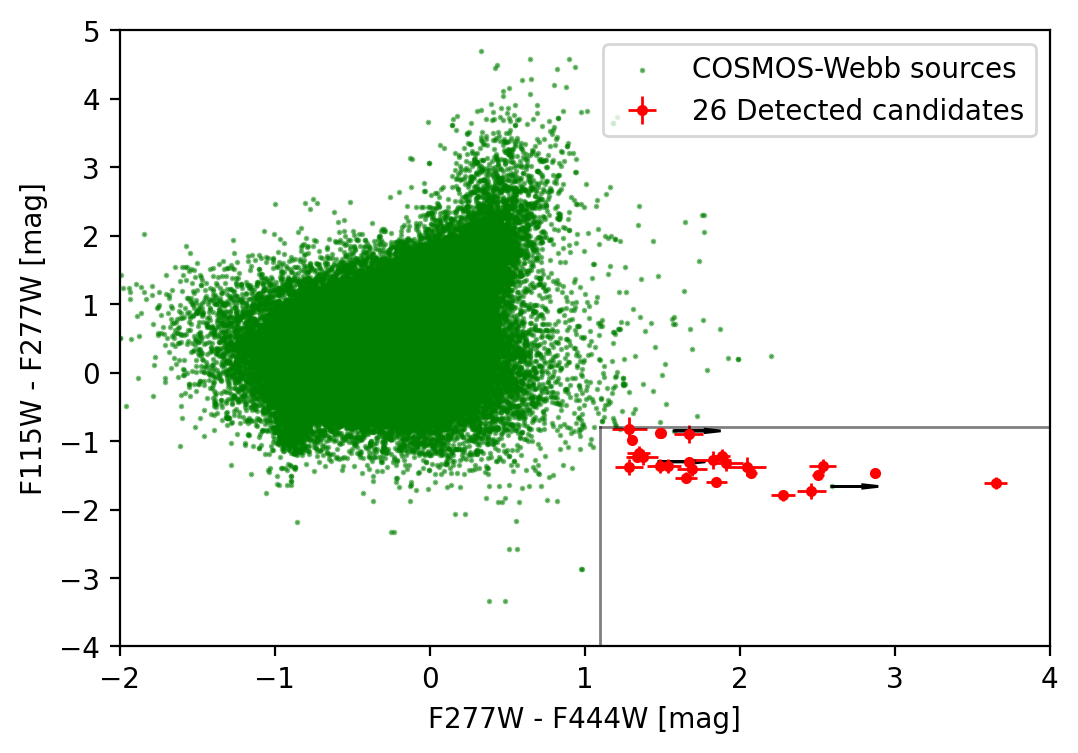

In [36]:
ccplot(data)

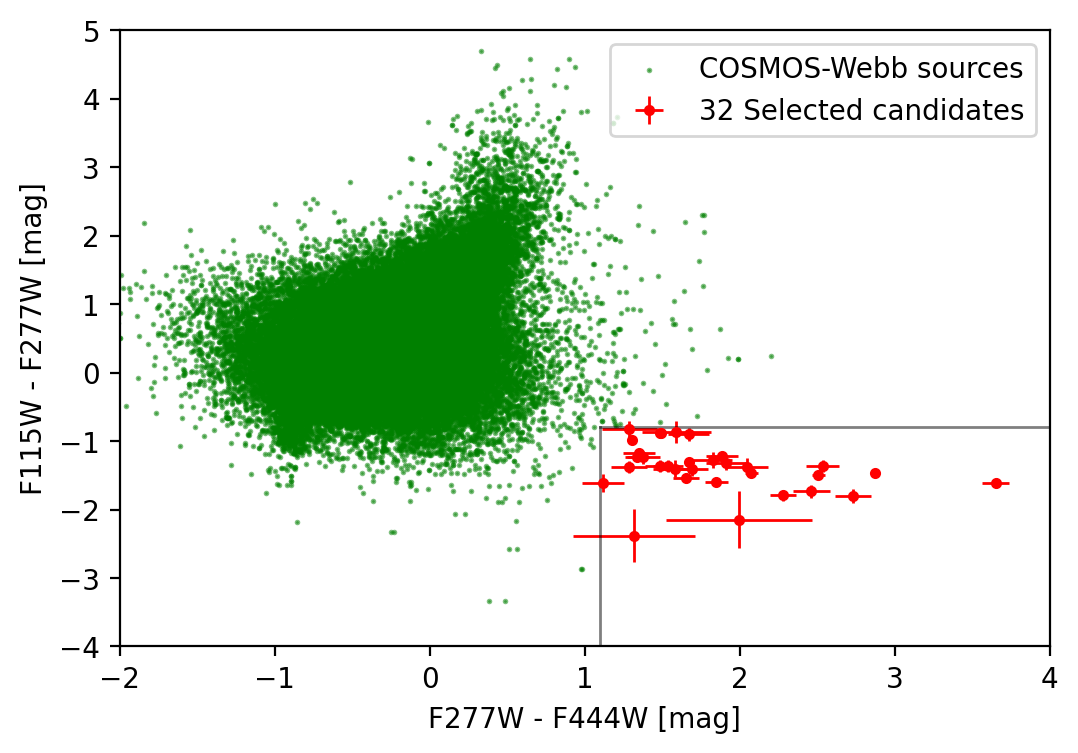

In [60]:
def ccplot(data, magtype='AUTO'):
    
    m444 = data[f'MAG_{magtype}_F444W']
    m277 = data[f'MAG_{magtype}_F277W']
    # m150 = data[f'MAG_{magtype}_F150W']
    m115 = data[f'MAG_{magtype}_F115W']

    selected = data.loc[(m277-m444>1.1)&(m115-m277<-0.8)]

    fig, ax = plt.subplots(figsize=(6, 4), dpi=200)


    ax.scatter(m277-m444, m115-m277, s=1, label='COSMOS-Webb sources', color='green', alpha=0.5)

    ax.errorbar(selected[f'MAG_{magtype}_F277W']-selected[f'MAG_{magtype}_F444W'], selected[f'MAG_{magtype}_F115W']-selected[f'MAG_{magtype}_F277W'], 
                np.sqrt(selected[f'MAGERR_{magtype}_F277W']**2+selected[f'MAGERR_{magtype}_F444W']**2), 
                np.sqrt(selected[f'MAGERR_{magtype}_F115W']**2+selected[f'MAGERR_{magtype}_F277W']**2),
            color='red', ls='', lw=1, fmt='.', label=f'{len(selected)} Selected candidates')
    ax.plot([1.1, 1.1], [-4, -0.8], color='black', lw=1, alpha=0.5)
    ax.plot([1.1, 5], [-0.8, -0.8], color='black', lw=1, alpha=0.5)

    ax.legend(loc='upper right')

    ax.set_xlim(-2, 4)
    ax.set_ylim(-4, 5)


    plt.xlabel('F277W - F444W [mag]')
    plt.ylabel('F115W - F277W [mag]')
    # plt.title(f'Color-color plot of all sources')

    plt.show()
    
    return selected
    
selected = ccplot(data, 'AUTO')

In [54]:
selected.to_csv('./CentralDogma/4_Greed_/selected.csv', index=False)

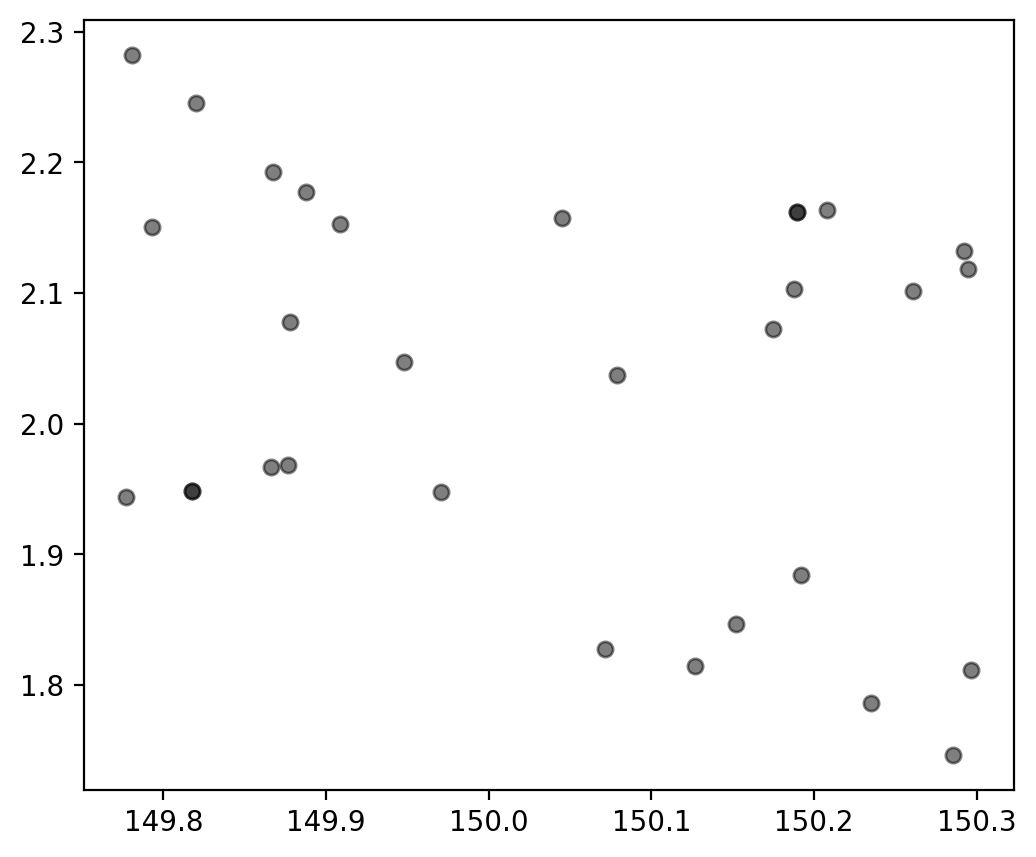

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=200)

ax.scatter(selected['ALPHA_J2000_F444W'], selected['DELTA_J2000_F444W'],
           s=30, c='k', alpha=0.5, label='all sources')

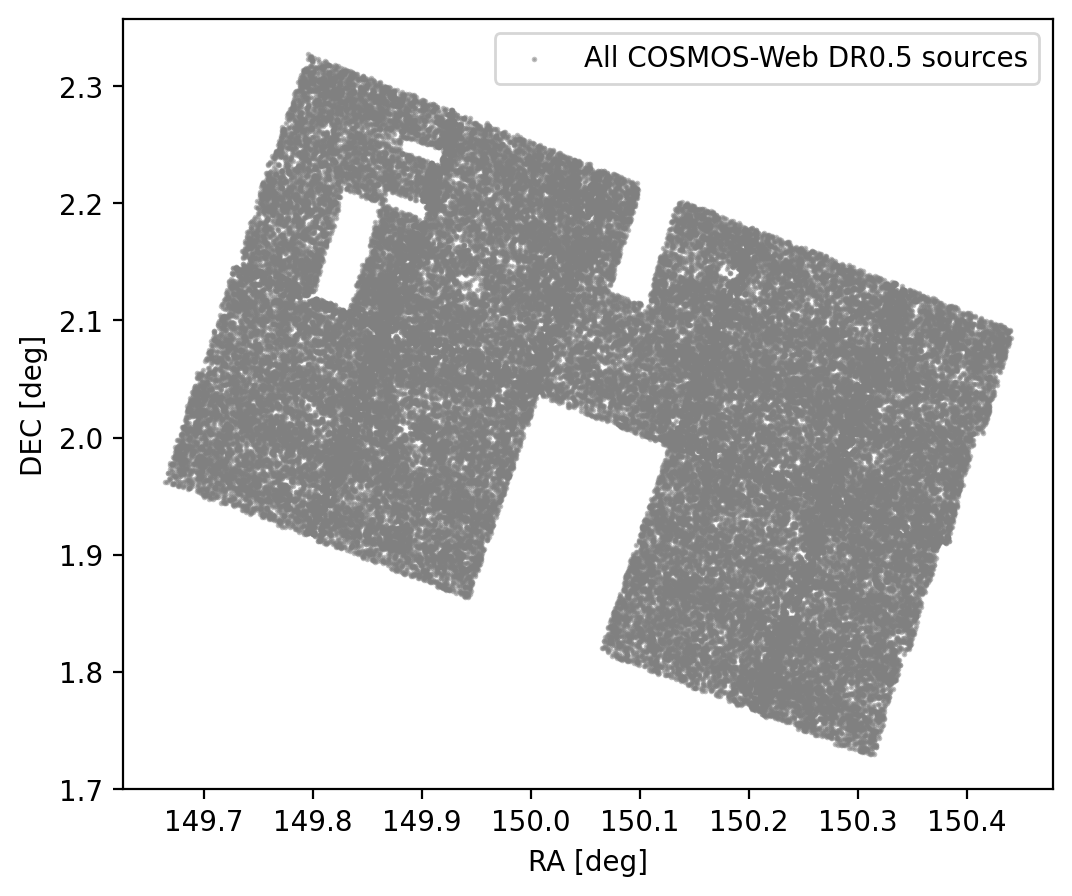

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5), dpi=200)

ax.scatter(data['ALPHA_J2000_F115W'], data['DELTA_J2000_F115W'], s=1,
           label='All COSMOS-Web DR0.5 sources', color='gray', alpha=0.5)

ax.set_xlabel('RA [deg]')
ax.set_ylabel('DEC [deg]')
ax.legend()

plt.show()

### Generate coordinate file for cutout and cross matching

In [17]:
coor = pd.read_csv('./CentralDogma/4_Greed_/selected.csv', usecols=['ALPHA_J2000_F115W', 'DELTA_J2000_F115W'])
# coor.to_csv('./CentralDogma/4_Greed_/coordinate.csv', index=False)

In [20]:
import pandas as pd
from astropy.io import ascii
from astropy.table import Table

# Convert the DataFrame to an Astropy Table
table = Table.from_pandas(coor)

# Define metadata for the IPAC table
table.meta['comments'] = ['This is a sample IPAC table with RA and DEC coordinates']

# Write the table to an IPAC format file
ascii.write(table, './CentralDogma/4_Greed_/coordinates.ipac', format='ipac', overwrite=True)

print("IPAC table written to 'coordinates.ipac'")

IPAC table written to 'coordinates.ipac'


### old

In [3]:
x = selected.loc[(selected.CLASS_STAR_F115W>0.8)]

In [14]:
y = selected.loc[(selected.CLASS_STAR_F444W>0.9)|(selected.CLASS_STAR_F277W>0.9)|(selected.CLASS_STAR_F150W>0.9)|(selected.CLASS_STAR_F115W>0.9) ]

In [14]:
selected.loc[(selected.CLASS_STAR_F444W>0.9)|(selected.CLASS_STAR_F277W>0.9)|(selected.CLASS_STAR_F150W>0.9)|(selected.CLASS_STAR_F115W>0.9) ].to_csv('./CentralDogma/3_Gluttony_/selectedv5_star_auto.csv', index=False)

In [7]:
data59 = pd.read_csv('./CentralDogma/3_Gluttony_/selectedv5_auto.csv')

ccmag = data59[['MAG_AUTO_F115W', 'MAGERR_AUTO_F115W', 'MAG_AUTO_F150W', 'MAGERR_AUTO_F150W', 'MAG_AUTO_F277W', 'MAGERR_AUTO_F277W', 'MAG_AUTO_F444W', 'MAGERR_AUTO_F444W']]
ccmag.to_csv('./CentralDogma/3_Gluttony_/ccmag_auto.csv', index=False)

## Crossmatch

#### A4 offset 

In [12]:
data = pd.read_csv('./CentralDogma/1_Limbo_/277x115.csv')

x = (data.ALPHA_J2000_1-data.ALPHA_J2000_2)*3600*np.cos(data.DELTA_J2000_1*np.pi/180)
y = (data.DELTA_J2000_1-data.DELTA_J2000_2)*3600

X = data.ALPHA_J2000_1.loc[(x>-0.2) & (x<-0.1) & (y>0) & (y<0.1)]
Y = data.DELTA_J2000_1.loc[(x>-0.2) & (x<-0.1) & (y>0) & (y<0.1)]

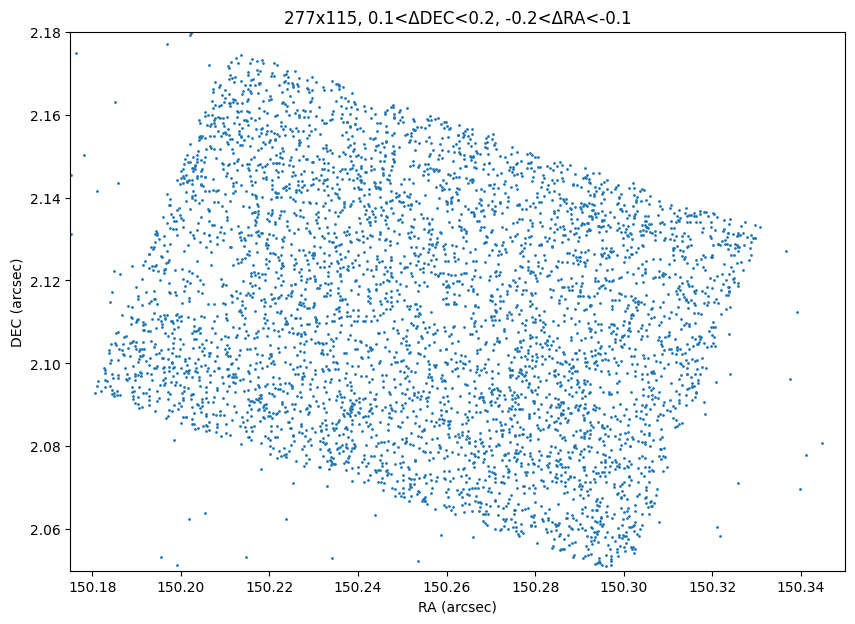

In [10]:
fig, ax = plt.subplots(figsize=(10,7))

ax.plot(X,Y,'o',markersize=1)

# ax.set_xlim(150.175, 150.35)
# ax.set_ylim(2.05, 2.18)

plt.xlabel('RA (arcsec)')
plt.ylabel('DEC (arcsec)')

plt.title('277x115, 0.1<ΔDEC<0.2, -0.2<ΔRA<-0.1')

plt.show()

### duplicated remove

In [ ]:
match_coordinates_sky(coords1, coords2, nthneighbor=2)

In [16]:
num1 = 5
num2 = 10
if num1<3 & num1>9:
  print("both are correct")
else:
  print ("one is wrong")

one is wrong


### replace the detection limit

In [2]:
Mlim = [27.45, 27.66, 28.28, 28.17]
F115W = pd.read_csv('./CentralDogma/1_Limbo_/F115Wcat.csv')
F150W = pd.read_csv('./CentralDogma/1_Limbo_/F150Wcat.csv')
F277W = pd.read_csv('./CentralDogma/1_Limbo_/F277Wcat.csv')
F444W = pd.read_csv('./CentralDogma/1_Limbo_/F444Wcat.csv')
F115W.loc[F115W['MAG_AUTO'] > Mlim[0], ['MAG_AUTO', 'MAGERR_AUTO']] = Mlim[0], -1
F150W.loc[F150W['MAG_AUTO'] > Mlim[1], ['MAG_AUTO', 'MAGERR_AUTO']] = Mlim[1], -1
F277W.loc[F277W['MAG_AUTO'] > Mlim[2], ['MAG_AUTO', 'MAGERR_AUTO']] = Mlim[2], -1
F444W.loc[F444W['MAG_AUTO'] > Mlim[3], ['MAG_AUTO', 'MAGERR_AUTO']] = Mlim[3], -1
F444W.to_csv('./CentralDogma/1_Limbo_/F444W.csv', index=False)
F277W.to_csv('./CentralDogma/1_Limbo_/F277W.csv', index=False)
F150W.to_csv('./CentralDogma/1_Limbo_/F150W.csv', index=False)
F115W.to_csv('./CentralDogma/1_Limbo_/F115W.csv', index=False)

In [3]:
# usecolumns = ['ALPHA_J2000', 'DELTA_J2000', 'MAG_AUTO', 'MAGERR_AUTO', 'CLASS_STAR']
usecolumns = ['MAG_AUTO', 'MAGERR_AUTO',
                'KRON_RADIUS', 'PETRO_RADIUS',
                'ALPHA_J2000', 'DELTA_J2000',
                'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'ELONGATION', 'ELLIPTICITY', 'CLASS_STAR', 'FLUX_RADIUS']
f444 = pd.read_csv('./CentralDogma/1_Limbo_/F444W.csv', usecols=usecolumns)
f277 = pd.read_csv('./CentralDogma/1_Limbo_/F277W.csv', usecols=usecolumns)
f150 = pd.read_csv('./CentralDogma/1_Limbo_/F150W.csv', usecols=usecolumns)
f115 = pd.read_csv('./CentralDogma/1_Limbo_/F115W.csv', usecols=usecolumns)

# F444x277 = crossmatch(f444, f277, radius=0.0425*8, offset=True)
# F444x277.to_csv('./CentralDogma/1_Limbo_/444x277_40sig.csv', index=False)
# F444x150 = crossmatch(f444, f150, radius=0.070*4)
# F444x150.to_csv('./CentralDogma/1_Limbo_/444x150_20sig.csv', index=False)
# F444x115 = crossmatch(f444, f115, radius=0.080*4)
# F444x115.to_csv('./CentralDogma/1_Limbo_/444x115_20sig.csv', index=False)

#### merge simply

In [4]:
F444x277 = crossmatch(f444, f277, radius=0.0425, offset=True)
F444x277.to_csv(
    './CentralDogma/1_Limbo_/444x277_5sig.csv', index=False,
    header = usecolumns + ['idx42', 'd2d42', 'MAG_AUTO_F277W', 'MAGERR_AUTO_F277W',
                'KRON_RADIUS_F277W', 'PETRO_RADIUS_F277W',
                'ALPHA_J2000_F277W', 'DELTA_J2000_F277W',
                'A_IMAGE_F277W', 'B_IMAGE_F277W', 'THETA_IMAGE_F277W', 'ELONGATION_F277W', 'ELLIPTICITY_F277W', 'CLASS_STAR_F277W', 'FLUX_RADIUS_F277W']            
)

In [6]:
column_names = usecolumns + ['idx42', 'd2d42', 'MAG_AUTO_F277W', 'MAGERR_AUTO_F277W',
                'KRON_RADIUS_F277W', 'PETRO_RADIUS_F277W',
                'ALPHA_J2000_F277W', 'DELTA_J2000_F277W',
                'A_IMAGE_F277W', 'B_IMAGE_F277W', 'THETA_IMAGE_F277W', 'ELONGATION_F277W', 'ELLIPTICITY_F277W', 'CLASS_STAR_F277W', 'FLUX_RADIUS_F277W']
level2 = pd.read_csv('./CentralDogma/1_Limbo_/444x277_5sig.csv')
level3 = crossmatch(level2, f150, radius=0.070)
level3.to_csv(
    './CentralDogma/1_Limbo_/444x277x150_5sig.csv', index=False,
    header = column_names + ['idx43', 'd2d43', 'MAG_AUTO_F150W', 'MAGERR_AUTO_F150W',
                'KRON_RADIUS_F150W', 'PETRO_RADIUS_F150W',
                'ALPHA_J2000_F150W', 'DELTA_J2000_F150W',
                'A_IMAGE_F150W', 'B_IMAGE_F150W', 'THETA_IMAGE_F150W', 'ELONGATION_F150W', 'ELLIPTICITY_F150W', 'CLASS_STAR_F150W', 'FLUX_RADIUS_F150W']
)

In [9]:
level3 = pd.read_csv('CentralDogma/1_Limbo_/444x277x150_5sig.csv')
level4 = crossmatch(level3, f115, radius=0.080)
level4.to_csv(
    './CentralDogma/1_Limbo_/merged_catalog_5sig.csv', index=False,
    header = ['MAG_AUTO_F444W', 'MAGERR_AUTO_F444W',
                'KRON_RADIUS_F444W', 'PETRO_RADIUS_F444W',
                'ALPHA_J2000_F444W', 'DELTA_J2000_F444W',
                'A_IMAGE_F444W', 'B_IMAGE_F444W', 'THETA_IMAGE_F444W', 'ELONGATION_F444W', 'ELLIPTICITY_F444W', 'CLASS_STAR_F444W', 'FLUX_RADIUS_F444W']            
                + ['idx42', 'd2d42', 'MAG_AUTO_F277W', 'MAGERR_AUTO_F277W',
                'KRON_RADIUS_F277W', 'PETRO_RADIUS_F277W',
                'ALPHA_J2000_F277W', 'DELTA_J2000_F277W',
                'A_IMAGE_F277W', 'B_IMAGE_F277W', 'THETA_IMAGE_F277W', 'ELONGATION_F277W', 'ELLIPTICITY_F277W', 'CLASS_STAR_F277W', 'FLUX_RADIUS_F277W']            
                + ['idx415', 'd2d415', 'MAG_AUTO_F150W', 'MAGERR_AUTO_F150W',
                'KRON_RADIUS_F150W', 'PETRO_RADIUS_F150W',
                'ALPHA_J2000_F150W', 'DELTA_J2000_F150W',
                'A_IMAGE_F150W', 'B_IMAGE_F150W', 'THETA_IMAGE_F150W', 'ELONGATION_F150W', 'ELLIPTICITY_F150W', 'CLASS_STAR_F150W', 'FLUX_RADIUS_F150W']
                + ['idx411', 'd2d411', 'MAG_AUTO_F115W', 'MAGERR_AUTO_F115W',
                'KRON_RADIUS_F115W', 'PETRO_RADIUS_F115W',
                'ALPHA_J2000_F115W', 'DELTA_J2000_F115W',
                'A_IMAGE_F115W', 'B_IMAGE_F115W', 'THETA_IMAGE_F115W', 'ELONGATION_F115W', 'ELLIPTICITY_F115W', 'CLASS_STAR_F115W', 'FLUX_RADIUS_F115W']
)

### separation as a function of magnitude

In [15]:
F444x277 = pd.read_csv('./CentralDogma/1_Limbo_/444x277_40sig.csv')
F444x150 = pd.read_csv('./CentralDogma/1_Limbo_/444x150_20sig.csv')
F444x115 = pd.read_csv('./CentralDogma/1_Limbo_/444x115_20sig.csv')

In [6]:
min(F444x115['MAG_AUTO_F115W'])

14.27848651938224

In [11]:
magnitude_bin = np.linspace(15, 29, 15)
magnitude_bin

array([15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29.])

0.012140606005478501


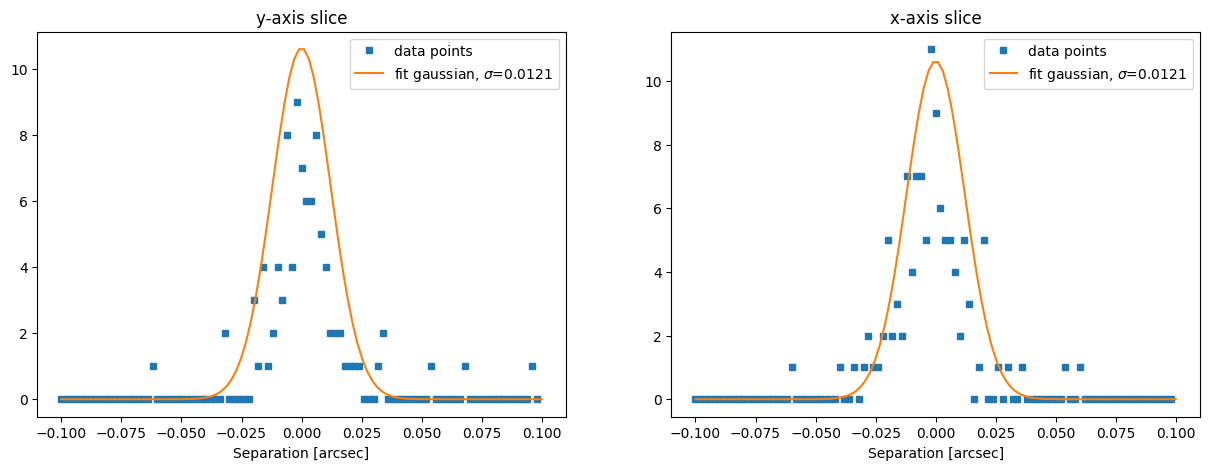

0.013365622666707547


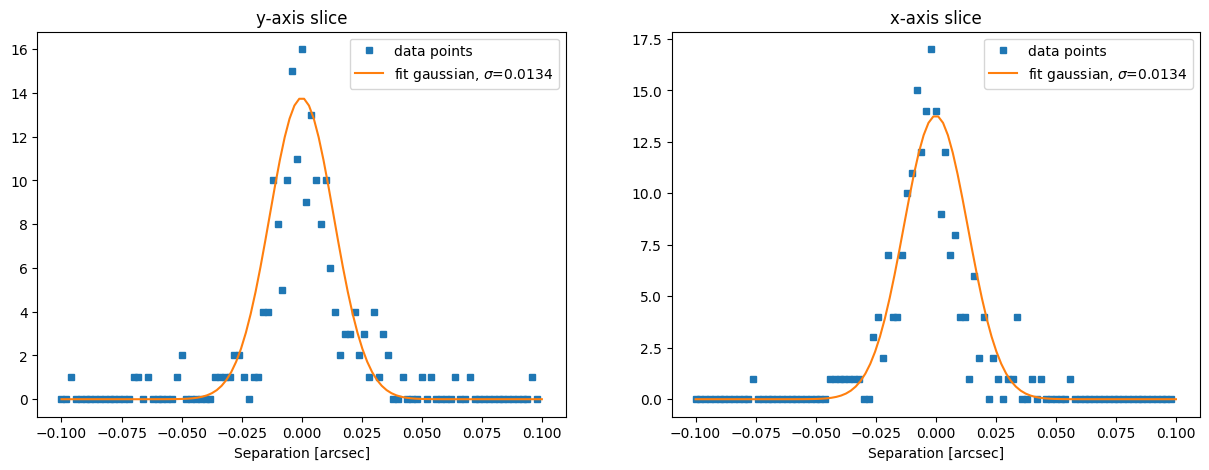

0.014308334837853313


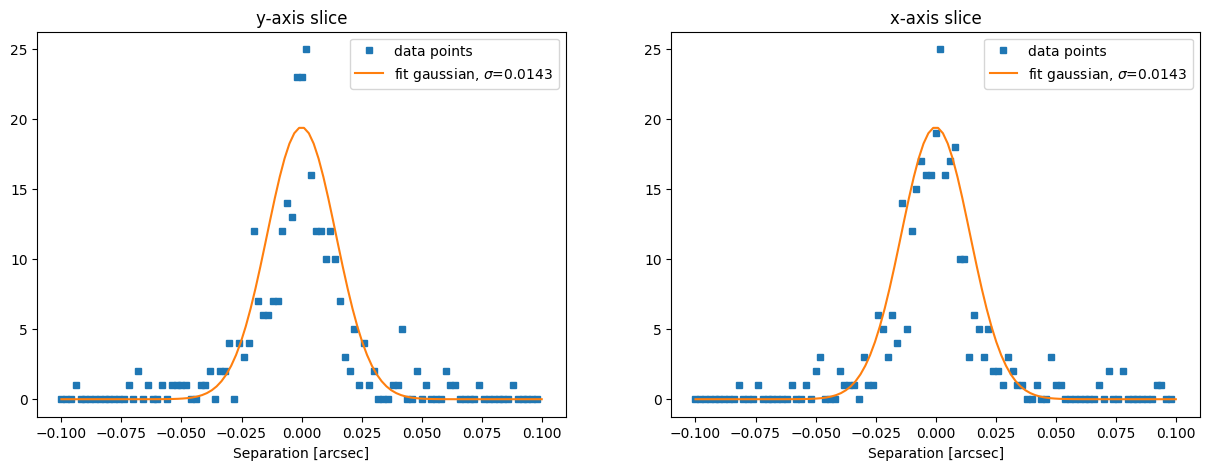

0.01466381840227852


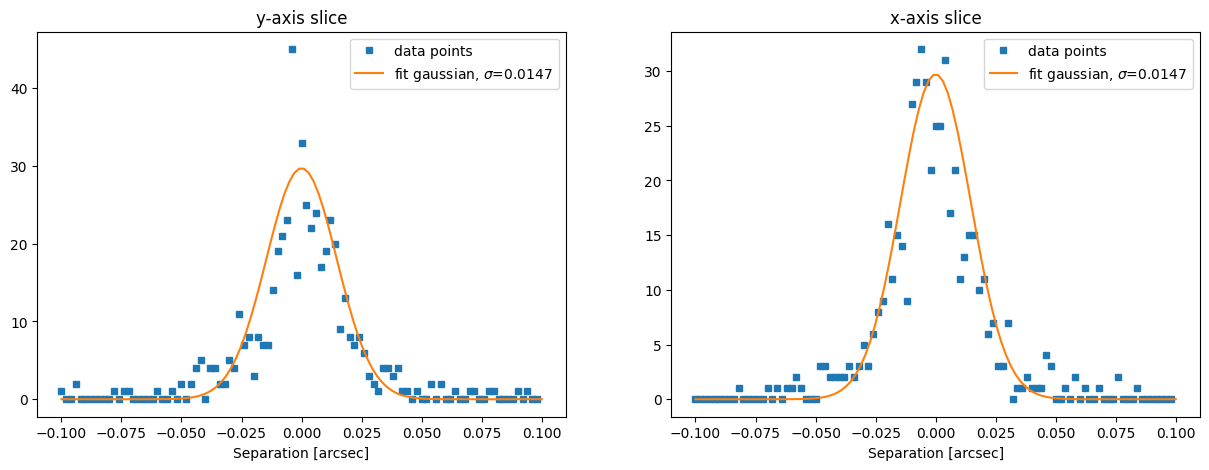

0.016934486958212893


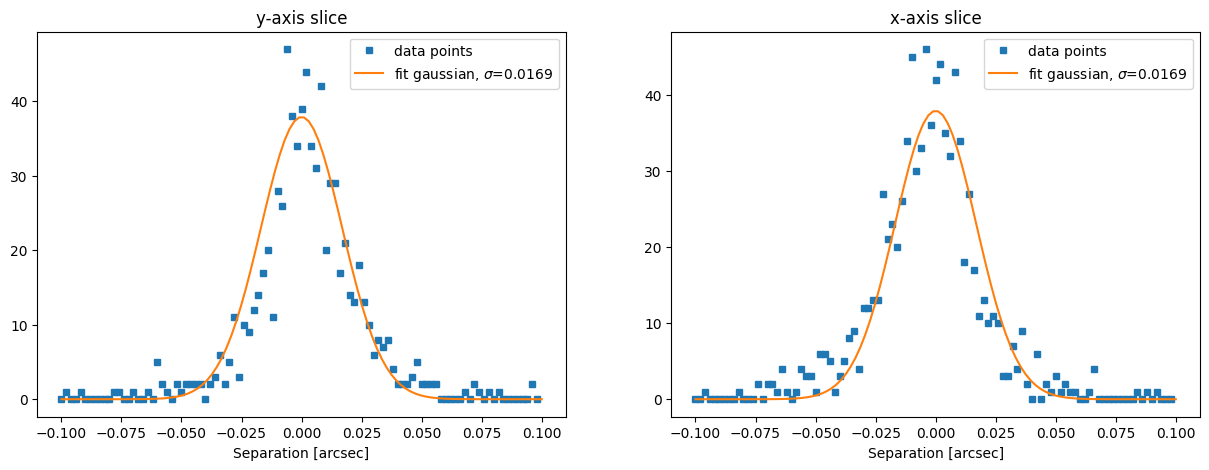

0.01850682541763777


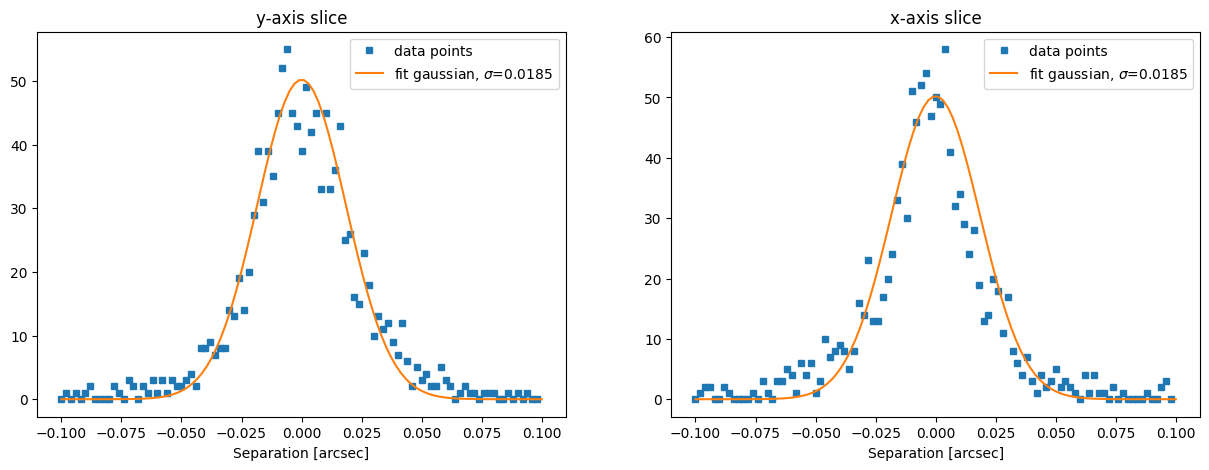

0.021191561102760874


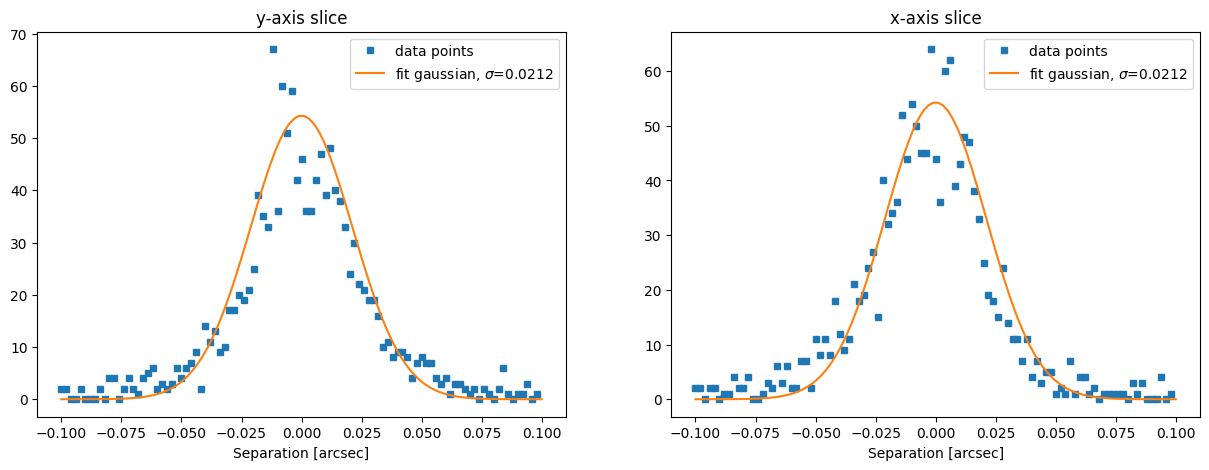

0.023757532973976123


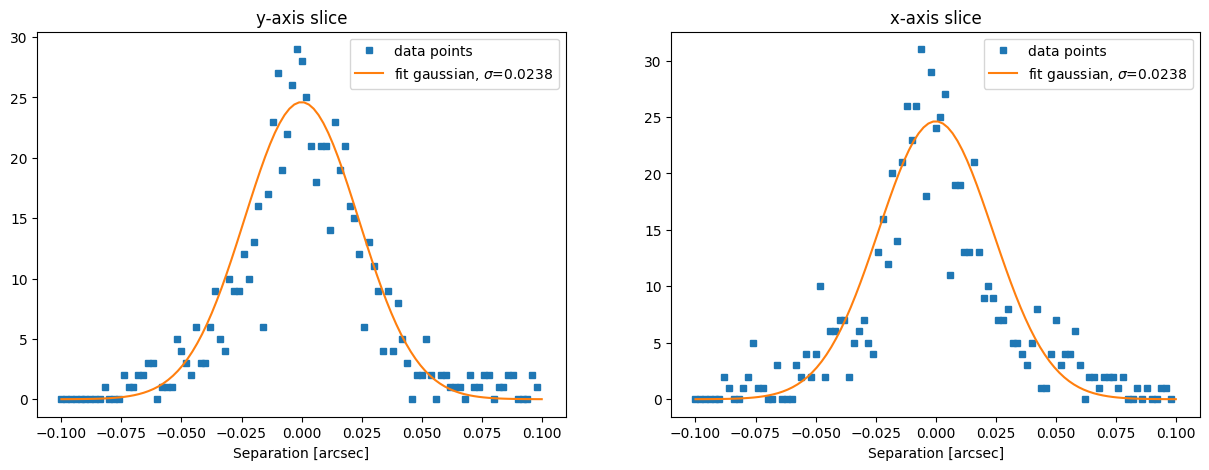

In [18]:
magnitude_bin = np.linspace(15, 29, 15)
F444x115sepsig = []

for i in range(len(magnitude_bin)-1):
    mag_bin_mask = (F444x115['MAG_AUTO_F115W']>magnitude_bin[i]) & (F444x115['MAG_AUTO_F115W']<magnitude_bin[i+1])
    data = F444x115.loc[
        mag_bin_mask,
        ['d2d','ALPHA_J2000', 'DELTA_J2000', 'ALPHA_J2000_F115W', 'DELTA_J2000_F115W']
        ]
    
    if len(data)>1200:
        x = CrossmatchDisfit(data,
                        cname=['ALPHA_J2000_F115W', 'DELTA_J2000_F115W'],
                        cname0=['ALPHA_J2000', 'DELTA_J2000'],
                        fitrange=0.1, grid=101, weight=1.5, mode=3)
        F444x115sepsig.append(
            [(magnitude_bin[i]+magnitude_bin[i+1])/2, x]
        )
    else:
        pass

In [49]:
pd.DataFrame(
    F444x277sepsig,
    columns=['m277', 'sigma277']
).to_csv('./CentralDogma/1_Limbo_/sepsig3.csv', index=False)

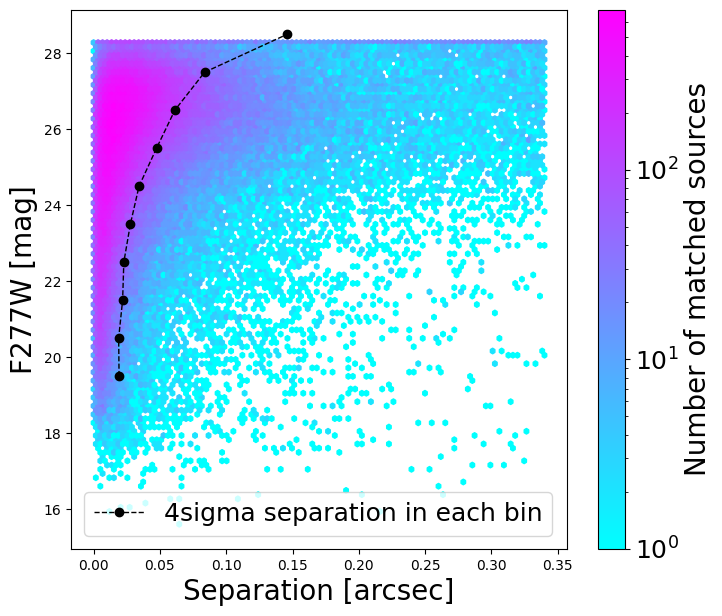

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8,7))

xlim = [-0.01, 0.30]

hb2 = ax.hexbin(F444x277['d2d'].loc[F444x277['MAG_AUTO_F277W']>14],
                F444x277['MAG_AUTO_F277W'].loc[F444x277['MAG_AUTO_F277W']>14],
                gridsize=100, cmap='cool', bins='log')
cb = fig.colorbar(hb2, ax=ax)
cb.set_label('Number of matched sources', fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.plot(4*pd.DataFrame(F444x277sepsig)[1], pd.DataFrame(F444x277sepsig)[0],
        'k--', marker='o', lw=1, label='4sigma separation in each bin')

ax.set_xlabel('Separation [arcsec]', fontsize=20)
ax.set_ylabel('F277W [mag]', fontsize=20)
# ax.set_xlim(xlim)
# ax.set_ylim(15, 29)

ax.legend(fontsize=18)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,7))

ax = axs[0]
hb1 = ax.hexbin(data['d2d'], data['MAG_AUTO'],
                gridsize=100, cmap='cool', bins='log')
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Number of matched sources', fontsize=20)
cb.ax.tick_params(labelsize=18)

(15.0, 29.0)

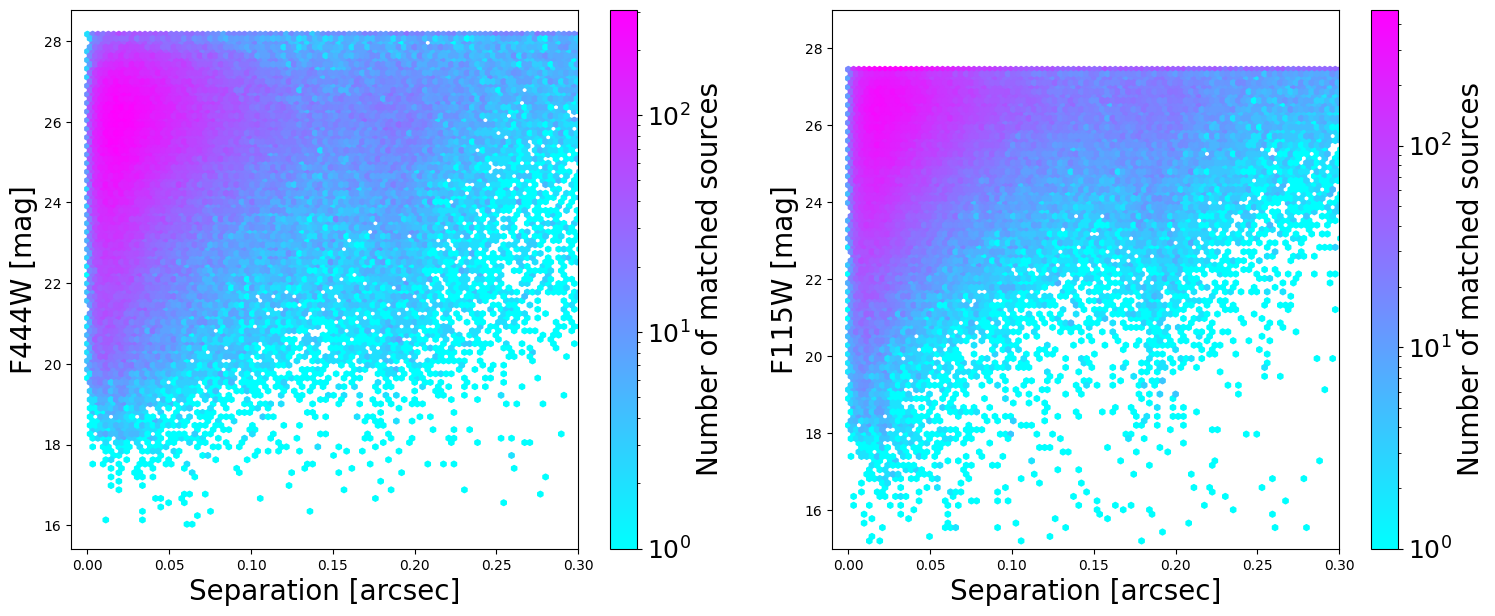

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(18,7))

xlim = [-0.01, 0.30]

ax = axs[0]
hb1 = ax.hexbin(F444x115['d2d'], F444x115['MAG_AUTO'],
                gridsize=100, cmap='cool', bins='log')
cb = fig.colorbar(hb1, ax=ax)
cb.set_label('Number of matched sources', fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.set_xlabel('Separation [arcsec]', fontsize=20)
ax.set_ylabel('F444W [mag]', fontsize=20)
ax.set_xlim(xlim)

ax = axs[1]
hb2 = ax.hexbin(F444x115['d2d'].loc[F444x115['MAG_AUTO_F115W']>14],
                F444x115['MAG_AUTO_F115W'].loc[F444x115['MAG_AUTO_F115W']>14],
                gridsize=100, cmap='cool', bins='log')
cb = fig.colorbar(hb2, ax=ax)
cb.set_label('Number of matched sources', fontsize=20)
cb.ax.tick_params(labelsize=18)

ax.set_xlabel('Separation [arcsec]', fontsize=20)
ax.set_ylabel('F115W [mag]', fontsize=20)
ax.set_xlim(xlim)
ax.set_ylim(15, 29)

### match catalog

In [22]:
def crossmatchv2(data1, data2, radius_df, msigma=4, offset=False):
    
    ''' Crossmatch two datasets using astropy.coordinates.match_coordinates_sky
    and return a merged dataset with matched rows from both datasets.
    
    Parameters:
    data1 (DataFrame): First dataset to crossmatch
    data2 (DataFrame): Second dataset to crossmatch
    radius_df (DataFrame): Maximum separation between matches in arcseconds
        as a function of magnitude, binsize is designed to be 1 mag
    msigma (int): Number of sigma to consider as a match
    offset (bool): Apply offset to the coordinates of data2
    
    Returns:
    merged_data (DataFrame): Merged dataset containing matched rows from data1 and data2
    
    ''' 
    
    # Create SkyCoord objects for both datasets
    coords1 = SkyCoord(ra=data1['ALPHA_J2000'], dec=data1['DELTA_J2000'], unit="deg")

    # Initialize lists to store match results
    all_d2d = []
    all_matched_data1 = []
    all_matched_data2 = []
    
    for i in range(len(radius_df)):
        
        magbin = [radius_df['mag'][i]-0.5, radius_df['mag'][i]+0.5]
        mag_mask = (data2['MAG_AUTO'] > magbin[0]) & (data2['MAG_AUTO'] < magbin[1])
        
        # Filter coords2 based on magnitude mask
        filtered_data2 = data2[mag_mask]
        # .reset_index(drop=True)
        print(i, len(filtered_data2))
        coords2 = SkyCoord(
            ra=filtered_data2['ALPHA_J2000'], dec=filtered_data2['DELTA_J2000'], 
            unit="deg"
        )
        
        if offset:
            # Define the region with offset
            region_mask = (
                (filtered_data2['DELTA_J2000'] < 2.79 * (filtered_data2['ALPHA_J2000'] - 150.18) + 2.0922) &
                (filtered_data2['DELTA_J2000'] > 2.79 * (filtered_data2['ALPHA_J2000'] - 150.305) + 2.0482) &
                (filtered_data2['DELTA_J2000'] > -0.352 * (filtered_data2['ALPHA_J2000'] - 150.18) + 2.0922)
            )
            
            # Apply offset to coords1 for sources in the specified region, for 277 band, A4
            coords2[region_mask] = SkyCoord(
                ra=coords2.ra[region_mask] + 0.18*u.arcsec,
                dec=coords2.dec[region_mask] - 0.06*u.arcsec,
                unit="deg"
            )
        
        if len(coords2) == 0:
            continue
        
        print(i, len(coords2))
        
        idx, d2d, d3d = match_coordinates_sky(coords1, coords2, nthneighbor=1)
        
        # print(len(coords1), len(coords2))
        
        radius_mask = d2d.arcsec <= (msigma*radius_df['sigma'][i])
        
        print(msigma*radius_df['sigma'][i])
        
        if np.any(radius_mask):
            matched_data1 = data1.iloc[idx[radius_mask]]
            # .reset_index(drop=True)
            matched_data2 = filtered_data2.iloc[idx[radius_mask]]
            # .reset_index(drop=True)
            
            print(i, len(matched_data1))
            
            all_matched_data1.append(matched_data1)
            all_matched_data2.append(matched_data2)
            all_d2d.append(d2d.arcsec[radius_mask])
        else:
            pass

    # Concatenate all matched results
    if all_matched_data1:
        matched_data1 = pd.concat(all_matched_data1)
        # .reset_index(drop=True)
        matched_data2 = pd.concat(all_matched_data2)
        # .reset_index(drop=True)
        separations = pd.Series(np.concatenate(all_d2d), name='separation_arcsec')
        
        # Merge matched rows from data1 and data2
        # merged_data = pd.concat([matched_data1, matched_data2, separations], axis=1)
    else:
        merged_data = pd.DataFrame()  # Return an empty DataFrame if no matches found

    return matched_data1, matched_data2, separations

In [13]:
# usecolumns = ['ALPHA_J2000', 'DELTA_J2000', 'MAG_AUTO', 'MAGERR_AUTO', 'CLASS_STAR']
usecolumns = ['MAG_AUTO', 'MAGERR_AUTO',
                'KRON_RADIUS', 'PETRO_RADIUS', 'FLUX_RADIUS',
                'ALPHA_J2000', 'DELTA_J2000',
                'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'ELONGATION', 'ELLIPTICITY', 'CLASS_STAR']
f444 = pd.read_csv('./CentralDogma/1_Limbo_/F444W.csv', usecols=usecolumns)
# f277 = pd.read_csv('./CentralDogma/1_Limbo_/F277W.csv', usecols=usecolumns)
f150 = pd.read_csv('./CentralDogma/1_Limbo_/F150W.csv', usecols=usecolumns)
# f115 = pd.read_csv('./CentralDogma/1_Limbo_/F115W.csv', usecols=usecolumns)
sepsig115 = pd.read_csv('./CentralDogma/1_Limbo_/sepsig115.csv')
sepsig150 = pd.read_csv('./CentralDogma/1_Limbo_/sepsig150.csv')
sepsig277 = pd.read_csv('./CentralDogma/1_Limbo_/sepsig277.csv')

In [24]:
testa, b, sep = crossmatchv2(f444, f150, sepsig150, msigma=1)
testa.to_csv('./CentralDogma/1_Limbo_/test_v4sig.csv', index=False)

0 0
1 2918
1 2918
0.0103610049370177
1 774
2 5479
2 5479
0.0100974091296331
2 1223
3 10103
3 10103
0.0121357943926863
3 2463
4 19351
4 19351
0.0128096153499254
4 4237
5 34885
5 34885
0.0134721388190594
5 6510
6 65248
6 65248
0.0166328598175498
6 11551
7 112919
7 112919
0.0194029236754222
7 16034
8 134188
8 134188
0.0237430301046407
8 9265
9 0


In [12]:
level2 = crossmatchv2(f444, f277, sepsig277, offset=True)
level2.to_csv('./CentralDogma/1_Limbo_/F444x277_v4sig.csv', index=False)

In [13]:
level2 = pd.read_csv('./CentralDogma/1_Limbo_/F444x277_v4sig.csv')
level3 = crossmatchv2(level2, f150, sepsig150)
level3.to_csv('./CentralDogma/1_Limbo_/F444x277x150_v4sig.csv', index=False)

In [4]:
level3 = pd.read_csv('./CentralDogma/1_Limbo_/F444x277x150_v4sig.csv')
merged = crossmatchv2(level3, f115, sepsig115)
merged.to_csv('./CentralDogma/1_Limbo_/merged_catalog_v4sig.csv', index=False)

IndexError: positional indexers are out-of-bounds

In [20]:
level2 = crossmatch(f444, f277, radius=0.0425*4, offset=True)
level2.to_csv('./CentralDogma/1_Limbo_/F444x277_20sig.csv', index=False)

In [51]:
level2 = pd.read_csv('./CentralDogma/1_Limbo_/F444x277_20sig.csv')
level3 = crossmatch(level2, f150, radius=0.07)
level3.to_csv('./CentralDogma/1_Limbo_/F444x277x150.csv', index=False)

In [52]:
level3 = pd.read_csv('./CentralDogma/1_Limbo_/F444x277x150.csv')
merged = crossmatch(level3, f115, radius=0.08)
merged.to_csv('./CentralDogma/1_Limbo_/merged_catalog_5sig.csv', index=False)

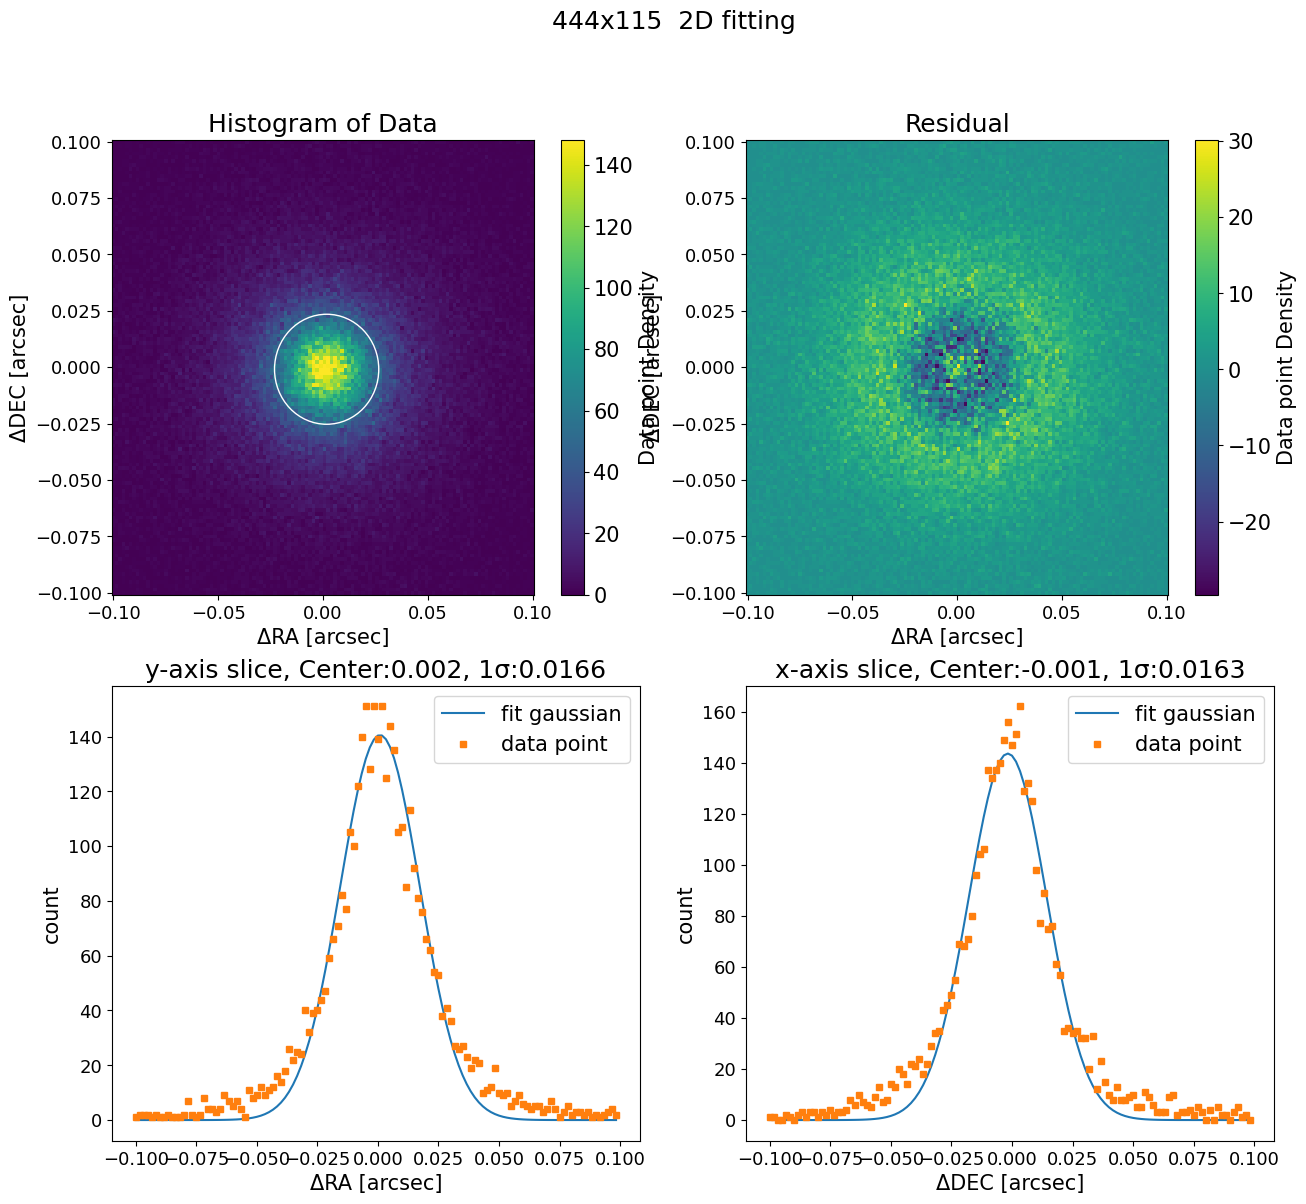

In [7]:
file = './CentralDogma/1_Limbo_/444x115.csv'
CrossmatchDisfit(file, fitrange=0.1, grid=121, weight=1, dim=2)

### Combine patches

In [9]:
column_name = ['NUMBER', 'MAG_ISO', 'MAGERR_ISO', 'MAG_APER', 'MAGERR_APER', 'MAG_AUTO', 'MAGERR_AUTO',
                'MAG_PETRO', 'MAGERR_PETRO', 'MAG_BEST', 'MAGERR_BEST', 'KRON_RADIUS', 'PETRO_RADIUS',
                'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000',
                'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 'ELONGATION', 'ELLIPTICITY', 'CLASS_STAR']

column_name2 = [
    'NUMBER', 'MAG_ISO', 'MAGERR_ISO', 'MAG_APER', 'MAGERR_APER', 'MAG_AUTO', 'MAGERR_AUTO', 
    'MAG_PETRO', 'MAGERR_PETRO', 'MAG_BEST', 'MAGERR_BEST', 'KRON_RADIUS', 'PETRO_RADIUS' ,
    'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000', 'A_IMAGE', 'B_IMAGE', 'THETA_IMAGE', 
    'ISO1', 'ISO2', 'ISO3', 'ISO4', 'ISO5', 'ISO6', 'ISO7', 'FWHM_IMAGE', 'ELONGATION', 'ELLIPTICITY', 'CLASS_STAR', 'FLUX_RADIUS'
]

cat_files = glob.glob('./cats/F444W*.cat')

df_csv_append = pd.DataFrame()
 
# append the CSV files
for file in cat_files:
    df = pd.read_csv(file, delimiter=' ', comment='#', names=column_name2)
    df_csv_append = pd.concat([df_csv_append, df])
    
df_csv_append.to_csv('./CentralDogma/1_Limbo_/F444Wcat.csv', index=False)